# GAN met Fashion MNIST

In deze notebook gaan we opnieuw beelden genereren op basis van de Fashin MNIST dataset, net zoals in de vorige notebook over variational autoencoders (VAE). 
Hierbij moeten we een generator en discriminator opstellen.

## Importeren van packages en dataset

Eerst importeren we alle benodigde Python-bibliotheken voor het bouwen, trainen en visualiseren van onze VAE.
We gebruiken Pytorch voor het bouwen van het neurale netwerk, matplotlib voor visualisaties en NumPy voor numerieke berekeningen.
Daarna laden we de Fashion MNIST dataset, normaliseren de pixelwaarden naar de range [-1,1] 
en splitsen de dataset in een trainings- en testset. We gebruiken DataLoader om mini-batches te maken voor training.

In [2]:
# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen -1 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteert beeld naar tensor
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader voor batches van de trainingsdata
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

print("Data geladen en DataLoader klaar.")

Data geladen en DataLoader klaar.


## Generator

 Deze cel definieert de generator die een random vector van ruis (latent vector) gebruikt om een afbeelding van 28x28 pixels te genereren. Het netwerk bestaat uit vier volledig verbonden lagen met ReLU-activatie, gevolgd door een Tanh activatie om de output te normaliseren.

In [30]:
latent_dim = 100

generator = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.BatchNorm1d(256),  # 2e best practice in CNN/GAN - stabieler leerproces
    nn.LeakyReLU(0.2),     # best practice in GAN - vermeidt dode neuronen
    nn.BatchNorm1d(256),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),     # best practice in GAN
    nn.BatchNorm1d(512),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),     # best practice in GAN
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 28*28), # 28 * 28 pixels -> dimensies van onze trainingsimages
    nn.Sigmoid()
).to(device)

print(generator)

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=512, out_features=1024, bias=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=1024, out_features=784, bias=True)
  (11): Sigmoid()
)


## Discriminator

Deze cel definieert de discriminator, die een afbeelding van 28x28 pixels als invoer ontvangt en een enkele waarde teruggeeft die aangeeft of de afbeelding echt is (uit de dataset) of vals (gegenereerd door de generator). Het netwerk bestaat uit vier volledig verbonden lagen met LeakyReLU-activatie en dropout om overfitting te voorkomen.

In [31]:
discr_in_dim = 28*28
discriminator = nn.Sequential(
    nn.Linear(discr_in_dim, 1024),
    nn.LeakyReLU(0.2),   
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2),   
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),   
    nn.Dropout(0.3),
    nn.Linear(256, 1), # dit is 1 omdat we binaire classificatie doen
).to(device)

print(discriminator)

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=1, bias=True)
)


## Loss functions

In deze cel worden de verliesfunctie en de optimalizers voor de generator en discriminator gedefinieerd. We gebruiken binaire cross-entropy (BCELoss) als verliesfunctie en de Adam-optimizer voor zowel de generator als de discriminator.

In [32]:
criterion = nn.BCEWithLogitsLoss() # dit is de loss functie voor binaire classificatie van de discriminator
#-> geen loss-functie voor generator nodig want de output gaat eerst door de descriminator

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)

## Trainen van het GAN model

De discriminator wordt getraind met zowel echte als gegenereerde afbeeldingen om te leren onderscheid te maken tussen de twee, terwijl de generator wordt getraind om betere afbeeldingen te genereren die de discriminator niet kan onderscheiden van echte. Voor elke epoch printen we het verlies van zowel de generator als de discriminator.

In [33]:
num_epochs = 10

for epoch in range(num_epochs):
    for images, _ in train_loader:
        batch_size = images.size(0)
        images = images.view(batch_size, -1).to(device) # doe een flatten
        ones = torch.ones(batch_size, 1).to(device) 
        zeros = torch.zeros(batch_size, 1).to(device)
        
        # stap 1: eerste batch met true images door de discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(images)
        loss_d_real = criterion(outputs, ones)
        loss_d_real.backward()
        # optimizer.step() doe ik maar op het einde

        # tweede stap: batch met fake images door de discriminator
        noise = torch.rand(batch_size, latent_dim).to(device)
        fake_images = generator(noise) # genereer fake beeldjes
        outputs = discriminator(fake_images)
        loss_d_fake = criterion(outputs, zeros)
        loss_d_fake.backward()

        optimizer_D.step() # pas hier de gewichten van de discriminator aan

        loss_d = loss_d_fake + loss_d_real

        # derde stap: train de generator
        optimizer_G.zero_grad()
        fake_images = generator(noise) # genereer fake beeldjes tweede keer (omdat na het uitvoeren van een backward de resources vrijgegeven worden
        outputs = discriminator(fake_images) # gewichten descriminator aangepast dus opnieuw classificeren
        loss_g = criterion(outputs, ones) # hier laten we ones staan want we wouden dat onze fakes echte waren
        loss_g.backward()
        optimizer_G.step()
        
    # Print verlies na elke epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {loss_d.item():.4f}, g_loss: {loss_g.item():.4f}")

Epoch [1/10], d_loss: 0.0434, g_loss: 11.3034
Epoch [2/10], d_loss: 0.0275, g_loss: 6.8369
Epoch [3/10], d_loss: 0.3224, g_loss: 4.4642
Epoch [4/10], d_loss: 0.0764, g_loss: 3.6162
Epoch [5/10], d_loss: 0.4535, g_loss: 7.0837
Epoch [6/10], d_loss: 0.0601, g_loss: 6.5621
Epoch [7/10], d_loss: 0.0938, g_loss: 2.8669
Epoch [8/10], d_loss: 0.1781, g_loss: 4.6586
Epoch [9/10], d_loss: 0.0580, g_loss: 6.2682
Epoch [10/10], d_loss: 0.2097, g_loss: 6.9569


## Visualiseren van de resultaten

Deze cel definieert een functie om enkele gegenereerde afbeeldingen van de getrainde generator te visualiseren. Het genereert willekeurige ruis en laat de generator nieuwe afbeeldingen maken, die vervolgens worden weergegeven met behulp van Matplotlib.

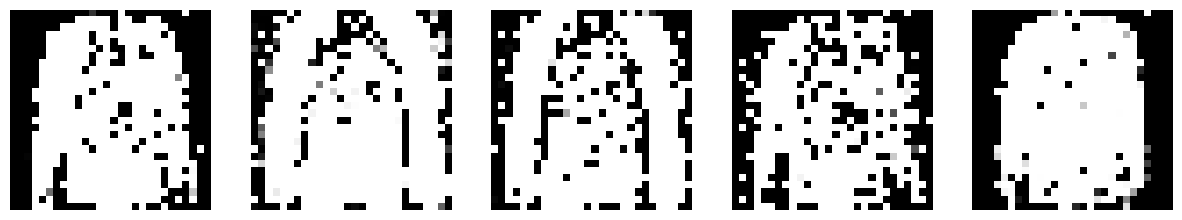

In [34]:
# Functie om gegenereerde afbeeldingen te visualiseren
def show_generated_images(generator, latent_dim, num_images=5):
    generator.eval()
    noise = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_images = generator(noise).cpu().view(num_images, 28, 28)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Visualiseer enkele gegenereerde afbeeldingen na training
show_generated_images(generator, latent_dim)